# CA1 Part4: LDA plus nearest neighbor classification results

In [1]:
import os
import sys
import cv2
import json
import numpy as np
from scipy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
from mpl_toolkits.mplot3d import Axes3D
from goto import with_goto
from math import log
import pandas as pd

In [2]:
# training image class
class Ti:
    def __init__(self):
        self.img = [] # pixel values
        self.feature = [] # feature vecter
        self.di = [] # dimensionality reduced feature
        self.id = 0 # -1 belongs to me
        self.trans = [] # data transform to new space
        self.prediction = 0 # predicted label only valid for test data
        

In [3]:
# collect all traning set data 
def alldata():
    # load current directory
    cur_dir = os.path.dirname(os.path.abspath("CA2_Part1.ipynb"))
    # PIE directory
    PIE_dir = cur_dir + '/PIE'
    # load json folder
    json_dir = PIE_dir + '/json'
    # read json files' name
    datanames = os.listdir(json_dir)
    datanames.remove('Me')
    datanames.remove('.DS_Store')

    # load all PIE data
    PIE_img = []
    for person in datanames:
        jsonfile = open(json_dir+'/'+person)
        img = json.load(jsonfile)

        # store the image information in class
        for im in img: 
            sample = Ti()
            sample.img = im
            sample.id = int(person)
            PIE_img.append(sample)
            
    # show the id of the data
    ID = []
    for sample in PIE_img:
        ID.append(sample.id)
    person = list(set(ID))
    person = sorted(person)
    print(person)

    ####
    # load my photo data set
    ####
    me_img = []
    jsonfile = open(json_dir+'/Me')
    img = json.load(jsonfile)

    # store the image information in class
    for im in img: 
        sample = Ti()
        sample.img = im
        sample.id = -1
        me_img.append(sample)
        
    return PIE_img, me_img

In [4]:
# select some dubjects in all data
def dataselect(data,num,ID = None):
    
    # input protect
    allID = []
    for sample in data:
        allID.append(sample.id)
    person = list(set(allID))
    
    if ID != None:
        # check inputs
        if len(ID) != num:
            raise ValueError('Input attributes not match!')
        for i in ID:
            if i not in person:
                raise ValueError('Input ID not exist!')
                
    else:
        ID = sorted(random.sample(person,num))
        print('Random selected id is :',ID)
    
    # select data with certain selected id  
    data_set = []
    for sample in data:
        if sample.id in ID:
            data_set.append(sample)
            
    return data_set, ID

In [5]:
# generate num numbers whose total is summary
# least : min value of every number
def sumran(num,summary,least = 1):
#     print(num,summary,least)
    n = num - 1
    loops = 0
    if summary/num < least:
        raise ValueError("input attributes are not resonable")
        
    elif int(summary/num) * 0.95 <= least:
        output = list(np.ones(num) * int(summary/num))
    
    else:
        while True:
            loops += 1
            points = random.sample(range(least,summary - least),n)
            points = sorted(points)
            points = [0] + points + [summary]

            output = []
            for i in range(1,num+1):
                output.append(points[i] - points[i-1])

            if min(output) > least:
                print(output)
                break
            elif loops > 10e8:
                raise ValueError("input attributes are not resonable")
        
    return output

In [6]:
# feature matrix generater
def Gfeature(data):

    size = len(data)
    fm = np.zeros([size,1024])
    # collect the id of data
    ID = np.zeros(size)
    for i in range(size):
        sample = data[i]
        if len(sample.feature) == 0:
            img = np.array(sample.img)
            feature = img.reshape(1,-1)
            sample.feature = list(feature)
            fm[i,:] = feature
            pid = sample.id
            ID[i] = pid
        elif len(sample.feature) == 1024:
            fm[i,:] = np.array(sample.feature)
            pid = sample.id
            ID[i] = pid
        else:
            img = np.array(sample.img)
            feature = img.reshape(1,-1)
            sample.feature = list(feature)
            fm[i,:] = feature
            pid = sample.id
            ID[i] = pid
        
    index = np.argsort(ID)
    fm = fm[index,:]
    ID = ID[index]
    
    return fm,ID,index

In [7]:
# get training data set and test data set
# ran_num == None : all data will be taken
def dataset(data,ran_per = None,ran_num = None,train_percent = 0.7,least_sample = 10):
    
    ID = []
    for sample in data:
        ID.append(sample.id)
    strID = [str(i) for i in ID]
    person = list(set(ID))
      
    if ran_num == None or ran_per == None:
        train_set = []
        test_set = []
        for ran_id in person:
            # get samples belongs to this id
            str_id = str(ran_id)
            sample_sum = strID.count(str_id)
            index_start = ID.index(ran_id)
            index_end = index_start + sample_sum
            id_samples = data[index_start:index_end]
            # random samples
            ran_id_samples = random.sample(id_samples,sample_sum)

            # generate data set
            train_num = round(train_percent * sample_sum) 
            train_set = train_set + ran_id_samples[:train_num]
            test_set = test_set + ran_id_samples[train_num:sample_sum]
        
    else:           
        flag = True
        loops = 0
        while flag:
            loops += 1
            print("trying to generate dataset: attempt ",loops)
            flag = False
            sel_id = random.sample(person,ran_per)

            # get number of images of every id 
            distribution = sumran(ran_per,ran_num,least = least_sample)
            
            train_set = []
            test_set = []
            # get the random samples
            for i in range(0,len(sel_id)):
                ran_id = sel_id[i]
                sample_num = distribution[i]
                str_id = str(ran_id)
                sample_sum = strID.count(str_id)
                
                # abnormal address
                if sample_sum < sample_num:
                    print("ab")
                    avalible = distribution[i:]
                    
                    if len(avalible) < 2:
                        flag = True
                        break
                    
                    min_ava = min(avalible)
                    if min_ava > sample_sum:
                        flag = True
                        break
                        
                    else:
                        # interchange the value in distribution
                        min_index = avalible.index(min_ava)
                        current_value = sample_num
                        avalible[0] = min_ava
                        avalible[min_index] = current_value
                        # change the value
                        distribution = distribution[:i] + avalible
                
                # reget sample number
                sample_num = int(distribution[i])        
                # get samples belongs to this id
                index_start = ID.index(ran_id)
                index_end = index_start + sample_sum
                id_samples = data[index_start:index_end]
                # random samples
#                 print(id_samples,sample_num)
                ran_id_samples = random.sample(id_samples,sample_num)
                
                # generate data set
                train_num = round(train_percent * sample_num) 
                train_set = train_set + ran_id_samples[:train_num]
                test_set = test_set + ran_id_samples[train_num:sample_sum]
            
            if loops > 500:
                raise ValueError("input attributes are not resonable")
    
    random.shuffle(train_set)
    random.shuffle(test_set)
    print("Done")
    
    return train_set,test_set

In [8]:
def LDA(train, num_feat = None):
    # get data matrix
    data,ID,index_train = Gfeature(train)
    [row,col] = data.shape
    
    # seperate the feature matrix by id
    listID = list(ID)
    person = list(set(ID))
    person = sorted(person)
    class_fm = []
    N = []
    for i in range(0,len(person)-1):
        index_start = listID.index(person[i])
        index_end = listID.index(person[i+1])
        Ni = index_end - index_start
        class_fm.append(data[index_start:index_end,:])
        N.append(Ni)
    class_fm.append(data[index_end:,:])
    Ni = row - index_end
    N.append(Ni)
        
    # input protect 
    if num_feat == None:
        num_feat = len(person) - 1
    # calculate the average of all samples
    avg_all = np.mean(data,axis=0) 
    # calculate the average of every class
    class_avg = []
    for child_fm in class_fm:
        avg = np.mean(child_fm,axis=0)
        class_avg.append(avg)
    # calculate Sw
    Sw = np.zeros([col,col])
    for child_fm in class_fm:
        Si = np.cov(child_fm.T)
        Sw += Si
    # calculate Sb
    Sb = np.zeros([col,col])
    for i in range(len(person)):
        Sb += N[i] * np.dot((class_avg - avg_all).T,(class_avg - avg_all))
    # calculate SwSb
    # if there is nan in Sw, turn it into beta
    beta = 10e-3
    Sw[np.isnan(Sw)] = beta
    SwSb = np.dot(linalg.inv(Sw),Sb) 
    # calculate eigenvalue
    eig_val, eig_vect = linalg.eig(SwSb) 
    # sort eigenvalue index form max to min
    eig_sorted = np.argsort(-eig_val)  
    
    # select component with contribution over 0.999
    if num_feat == -1:
        sum_eig = np.sum(eig_val)
        ratio = 0
        num_feat += 1
        while(ratio < 0.999):
            num_feat += 1
            ratio = np.sum(eig_val[0:num_feat])/sum_eig
            
    W = eig_vect[:,eig_sorted]   
    # transform data to new dimentionality
    trans_data = np.dot(data,W.T)   
    # reduced dimentional data
    reduced = trans_data[:,:num_feat]
    
    # store the di and trans
    for i in range(row):
        index = index_train[i]
        sample = train[index]
        sample.di = list(trans_data[i])
        sample.trans = list(reduced[i])
    
    return reduced, W, num_feat

In [9]:
# K-NN K Nearest Neighbor
def KNN(train,test,feature_dimension,K = 1,train_m = 0):
    # train : training data set, Ti class data
    # test : test point, Ti class data
    # k : number, int
    
    # generate training dataset matrix
    if len(train_m) == 1:
        train_m = np.mat(np.zeros(feature_dimension))
        for sample in train:
            train_m = np.concatenate((train_m,np.mat(sample.di[:feature_dimension])),axis = 0)
        train_m = np.mat(train_m)
        train_m = train_m[1:]
    elif train_m.shape != (len(train),feature_dimension):
        raise ValueError('Input attributes not match!')
        
    
    test_di = list(test.di[:feature_dimension])
    test_di= np.mat(test_di)
#     print(test_di)
    
    # calculate distance : Euclidean distance
    [row,col] = train_m.shape
    test_m = np.dot(np.ones([row,1]),test_di)
    diff = train_m - test_m
    dis = np.sqrt(np.sum(np.multiply(diff,diff),axis = 1)).T
    dis = np.array(dis)
    
    # find the nearest K points
    index = np.argsort(dis[0,:]).tolist()
    if K < 1:
        raise ValueError("invalide K")
        
    elif K == 1:
        label = train[index[0]].id
        
    else:
        index_k = index[:K]

        # investigate the id of K neighbors
        dis_k = []
        kid = []
        knum = []
        kdis = []
        for p in index_k:
            dis_k.append(dis[0][p])
            p_id = train[p].id

            if p_id not in kid:
                kid.append(p_id)
                knum.append(1)
                kdis.append(dis[0][p])
            else:
                index_p = kid.index(p_id)
                knum[index_p] += 1
                kdis[index_p] += dis[0][p]

        # find the id appears most of times
        maxnum = max(knum)
        maxpos = [i for i, x in enumerate(knum) if x == maxnum]
        if len(maxpos) == 1:
            label = kid[maxpos[0]]
            
        # if every id appears once, choose the nearest point label
        elif maxnum == 1:
            in_label = dis_k.index(min(dis_k))
            label = kid[in_label]
            
        else:
            min_dis = kdis[maxpos[0]]
            for point in maxpos:
                if kdis[point] <= min_dis:
                    min_dis = kdis[point]
                    label = kid[point]
    
    return label

In [10]:
# fit test data
def fitting(train, test, feature_dimension = None, K = 1):
    
    #
    # training model
    #
    _,W,feature_dimension = LDA(train,feature_dimension)
    print('feature_dimension = ',feature_dimension)
    print('Training done!')
    
    #
    # test data feature generation 
    #
    # get test matrix
    test_m,_,index_test = Gfeature(test)
    [row,col] = test_m.shape
    
    # transform data to new dimentionality
    trans_data = np.dot(test_m,W.T)
    # reduced dimentional data
    reduced = trans_data[:,:feature_dimension]
    
    # store the di and trans
    for i in range(row):
        index = index_test[i]
        sample = test[index]
        sample.di = list(trans_data[i])
        sample.trans = list(reduced[i])
        
    print('Testing done!')
        
    #
    # get predicted label
    #
    mtrain = np.mat(np.zeros(feature_dimension))
    for sample in train:
        mtrain = np.concatenate((mtrain,np.mat(sample.di[:feature_dimension])),axis = 0)
    mtrain = np.mat(mtrain)
    mtrain = mtrain[1:]
#     print(mtrain.shape,len(train))

#     i = 0
    for sample in test:
        label = KNN(train,sample,feature_dimension,K,train_m = mtrain)
        sample.prediction = label
#         i += 1
#         if i % int(row/10) == 0:
#             print('Prediction complete %.2f%%' % ( i / row ) * 100 + '\n' )
    
    print('Prediction done!')

In [11]:
# plot confusion matrix
def confusion_matrix(test):

    # generate classes
    ID = []
    for sample in test:
        ID.append(sample.id)
    person = list(set(ID))
    
    # generate confusion matrix
    confusion_matrix = np.zeros([len(person),len(person)],dtype = np.int32)
    for sample in test:
        truth = sample.id
        prediction = sample.prediction
        x = person.index(truth)
        y = person.index(prediction)
        confusion_matrix[x,y] += 1
    
    # get proportion of every grid
    proportion=[]
    for i in confusion_matrix:
        for j in i:
            temp=j/(np.sum(i))
            proportion.append(temp)

    # generate the percentage
    percentage=[]
    for i in proportion:
        pt="%.2f%%" % (i * 100)
        percentage.append(pt)
        
    proportion=np.array(proportion).reshape(len(person),len(person))  
    percentage=np.array(percentage).reshape(len(person),len(person))
    
    # set the font
    config = {"font.family":'Arial'}
    rcParams.update(config)
    
    #
    # plot the confusion matrix
    #
    fig = plt.figure( figsize=(12,12) )
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Oranges)  
                # ('Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd',
                # 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn')
    plt.title('Confusion Matrix',fontsize='xx-large',fontweight='heavy')
    plt.colorbar()
    tick_marks = np.arange(len(person))
    plt.xticks(tick_marks, person)
    plt.yticks(tick_marks, person)

    # plot the percentage
    thresh = confusion_matrix.max() / 2.
    fs = int( 9 / log(len(person),10)) 
    iters = np.reshape([[[i,j] for j in range(len(person))] for i in range(len(person))],(confusion_matrix.size,2))
    for i, j in iters:
        if(i==j):
            plt.text(j, i - 0.12, format(confusion_matrix[i, j]), va='center', ha='center',color='white',weight=5,fontsize=fs)  
            plt.text(j, i + 0.12, percentage[i, j], va='center', ha='center',color='white',fontsize=fs)
        else:
            plt.text(j, i-0.12, format(confusion_matrix[i, j]),va='center',ha='center',fontsize=fs)   
            plt.text(j, i+0.12, percentage[i, j], va='center', ha='center',fontsize=fs)

    plt.ylabel('True label',fontsize=16)
    plt.xlabel('Predict label',fontsize=16)
    plt.tight_layout()
    plt.show()
 

In [12]:
# show the score of model
def score(test):
    total = len(test)
    
    # generate classes
    ID = []
    for sample in test:
        ID.append(sample.id)
    person = list(set(ID))
    
    # generate confusion matrix
    confusion_matrix = np.zeros([len(person),len(person)],dtype = np.int32)
    for sample in test:
        truth = sample.id
        prediction = sample.prediction
        x = person.index(truth)
        y = person.index(prediction)
        confusion_matrix[x,y] += 1
    
    # calculate accuarcy
    TP_m = np.sum(confusion_matrix * np.eye(len(person)).astype(int),axis = 1)
    TP = np.sum(TP_m)
    accuracy = TP / total 
    print('The accuracy of the model is %.2f%%' % (accuracy * 100))
    
    # calculate recall
    FN = np.sum(np.triu(confusion_matrix, k = 1))
    recall = TP / ( TP + FN )
    print('The recall of the model is %.2f%%' % (recall * 100))
    
    # calculate precision
    FP = np.sum(np.tril(confusion_matrix, k = -1))
    precision = TP / ( TP + FP )
    print('The precision of the model is %.2f%%' % (precision * 100))
    
    # calculate F1
    F1 = 2 * recall * precision / ( recall + precision )
    print('The F1 of the model is %.2f%%' % (F1 * 100))
    
    return accuracy, recall, precision, F1

In [39]:
def LDA_info(train,num_feat = None):
    # get data matrix
    data,ID,index_train = Gfeature(train)
    [row,col] = data.shape
    
    # seperate the feature matrix by id
    listID = list(ID)
    person = list(set(ID))
    person = sorted(person)
    class_fm = []
    N = []
    for i in range(0,len(person)-1):
        index_start = listID.index(person[i])
        index_end = listID.index(person[i+1])
        Ni = index_end - index_start
        class_fm.append(data[index_start:index_end,:])
        N.append(Ni)
    class_fm.append(data[index_end:,:])
    Ni = row - index_end
    N.append(Ni)
        
    # input protect 
    if num_feat == None:
        num_feat = len(person) - 1
    # calculate the average of all samples
    avg_all = np.mean(data,axis=0) 
    # calculate the average of every class
    class_avg = []
    for child_fm in class_fm:
        avg = np.mean(child_fm,axis=0)
        class_avg.append(avg)
    # calculate Sw
    Sw = np.zeros([col,col])
    for child_fm in class_fm:
        Si = np.cov(child_fm.T)
        Sw += Si
    # calculate Sb
    Sb = np.zeros([col,col])
    for i in range(len(person)):
        Sb += N[i] * np.dot((class_avg - avg_all).T,(class_avg - avg_all))
    # calculate SwSb
    # if there is nan in Sw, turn it into beta
    beta = 10e-3
    Sw[np.isnan(Sw)] = beta
    SwSb = np.dot(linalg.inv(Sw),Sb) 
    # calculate eigenvalue
    eig_val, eig_vect = linalg.eig(SwSb) 
    # sort eigenvalue index form max to min
    eig_sorted = np.argsort(-eig_val)  
    
    # select component with contribution over 0.999
    sum_eig = np.sum(eig_val)
    ratio = 0
    number_feat = range(num_feat)
    r = []
    for i in number_feat:
        ratio += eig_val[i]/sum_eig
        r.append(ratio)
    
    plt.figure()
    plt.plot(number_feat,r)
    plt.plot(number_feat,np.ones((num_feat,1)))
    plt.title('LDA dimension component information',fontsize='xx-large',fontweight='heavy')
    plt.xlabel('Dimension',fontsize=16)
    plt.show()

## Read all the data

In [13]:
PIE,Me = alldata()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]


## Select 25 subjects in all 

In [15]:
# randomly select
selectedid = [3, 5, 7, 8, 13, 14, 15, 16, 19, 20, 22, 25, 31, 32, 37, 42, 45, 46, 48, 49, 59, 60, 62, 63, 64]
data,selected = dataselect(PIE,25,selectedid) 

# CMU PIE test images

## Train the model with 2 dimension and NN classification

Done
feature_dimension =  2
Training done!
Testing done!
Prediction done!


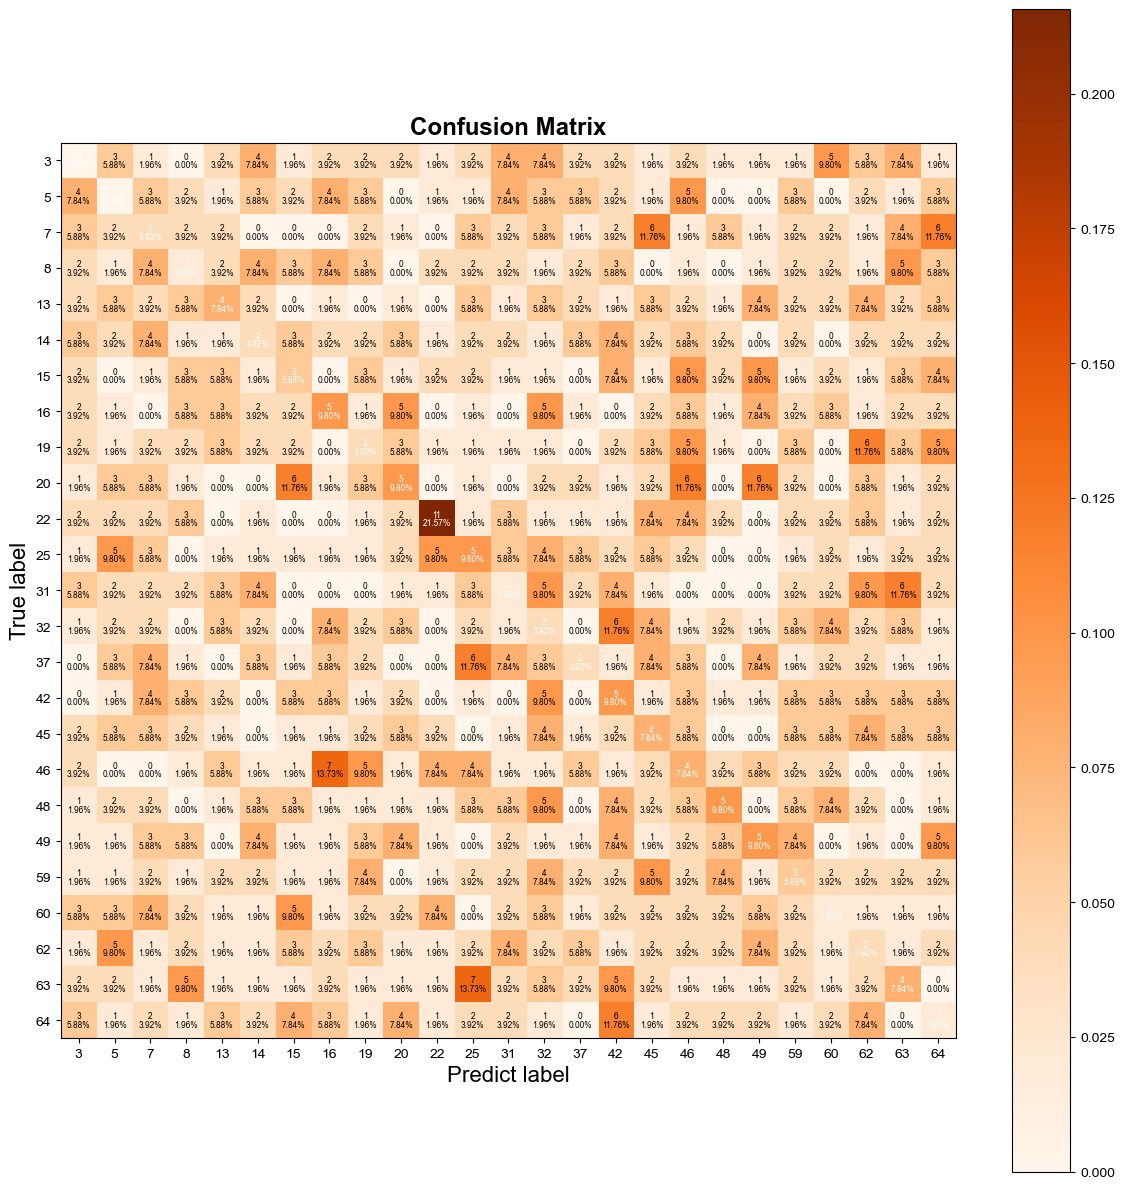

The accuracy of the model is 6.20%
The recall of the model is 11.55%
The precision of the model is 11.79%
The F1 of the model is 11.67%


In [16]:
train,test = dataset(data,train_percent = 0.7)

fitting(train, test, feature_dimension = 2, K = 1)

confusion_matrix(test)

_,_,_,_ = score(test)

## Train the model with 3 dimension and NN classification

Done
feature_dimension =  3
Training done!
Testing done!
Prediction done!


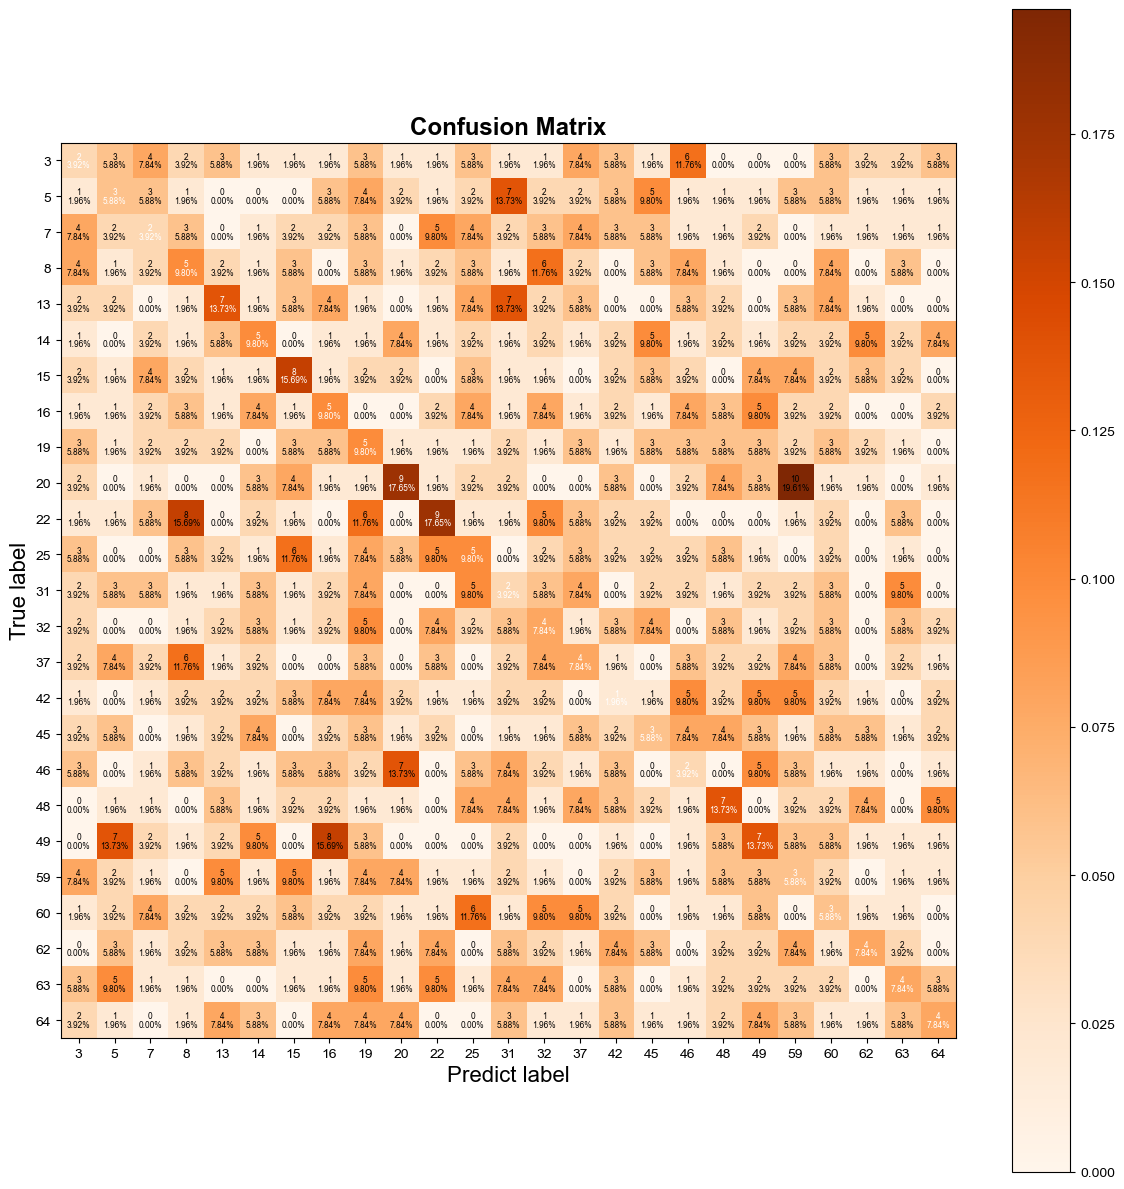

The accuracy of the model is 8.86%
The recall of the model is 16.52%
The precision of the model is 16.05%
The F1 of the model is 16.28%


In [17]:
train,test = dataset(data,train_percent = 0.7)

fitting(train, test, feature_dimension = 3, K = 1)

confusion_matrix(test)

_,_,_,_ = score(test)

## Train the model with 9 dimension and NN classification

Done
feature_dimension =  9
Training done!
Testing done!
Prediction done!


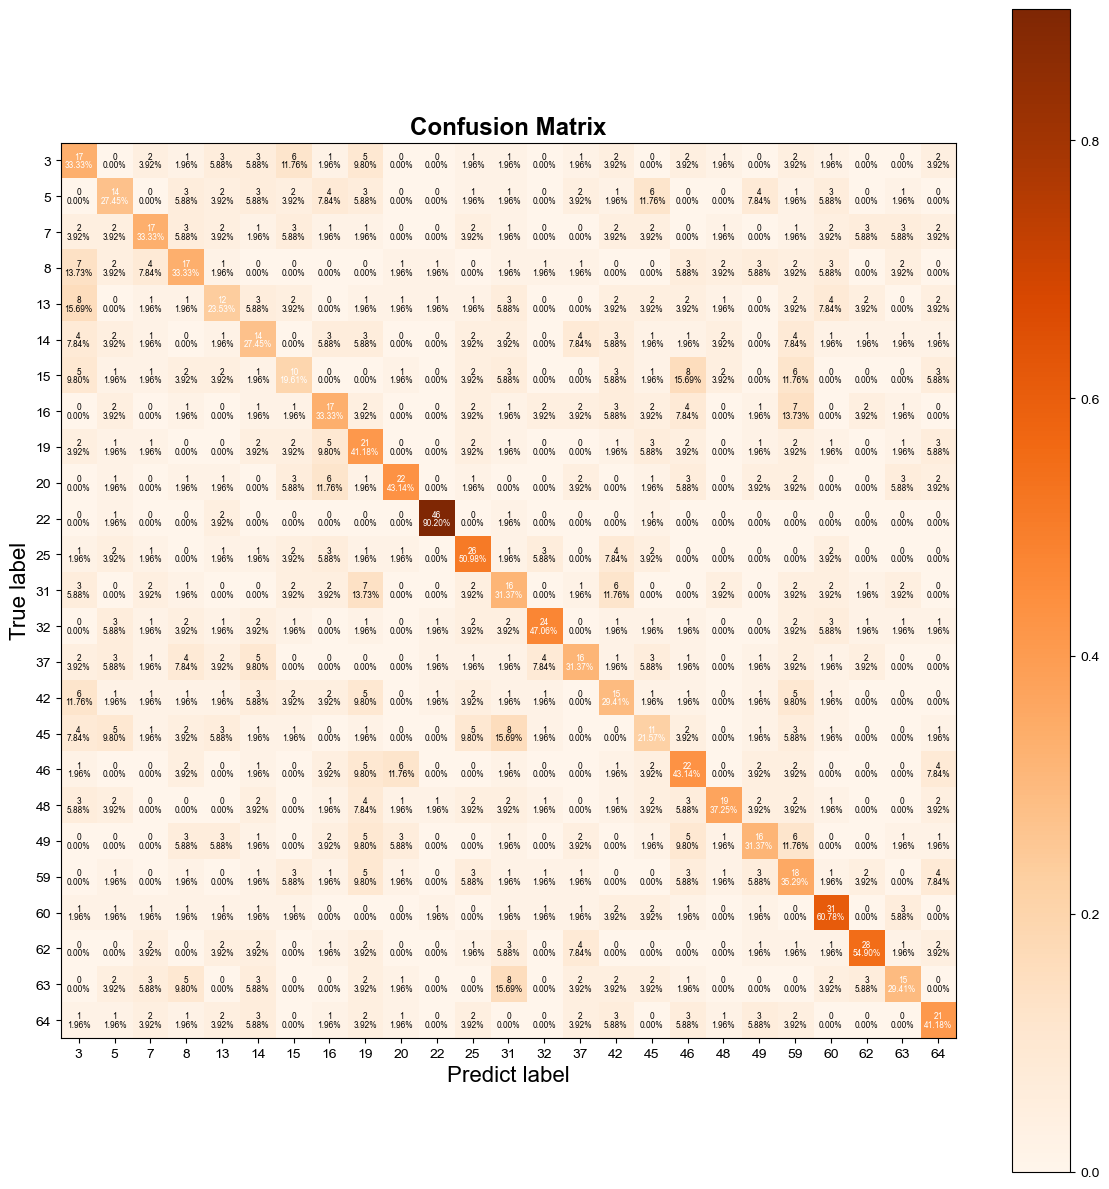

The accuracy of the model is 38.04%
The recall of the model is 56.33%
The precision of the model is 53.95%
The F1 of the model is 55.11%


In [19]:
train,test = dataset(data,train_percent = 0.7)

fitting(train, test, feature_dimension = 9, K = 1)

confusion_matrix(test)

_,_,_,_ = score(test)

# CMU PIE test images and my own images

In [20]:
datame = data + Me

## Train the model with 2 dimension and NN classification

Done
feature_dimension =  2
Training done!
Testing done!
Prediction done!


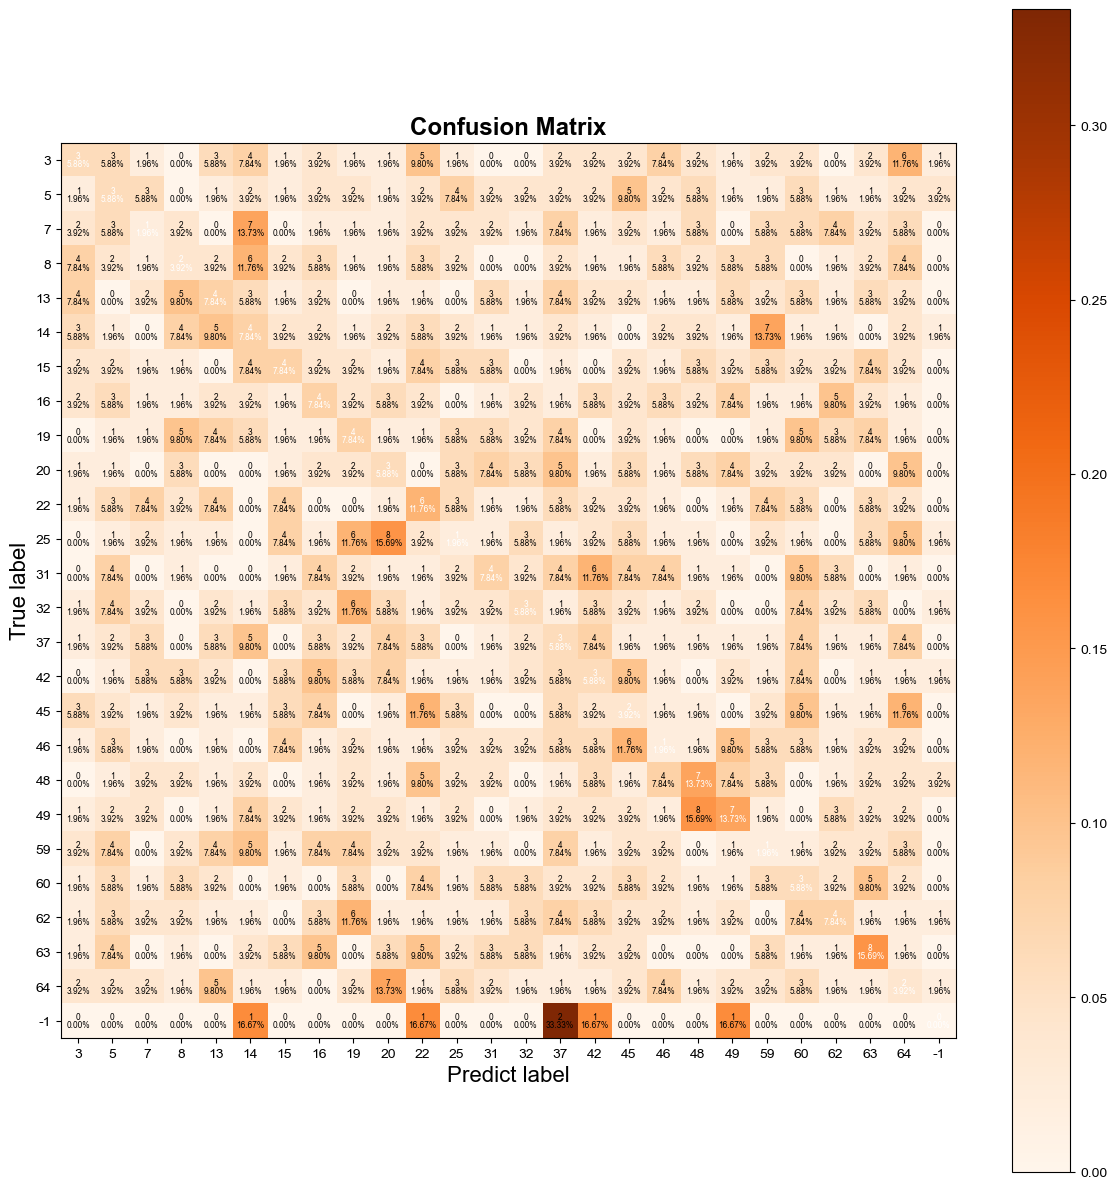

The accuracy of the model is 6.79%
The recall of the model is 12.55%
The precision of the model is 12.89%
The F1 of the model is 12.72%


In [21]:
train,test = dataset(datame,train_percent = 0.7)

fitting(train, test, feature_dimension = 2, K = 1)

confusion_matrix(test)

_,_,_,_ = score(test)

## Train the model with 3 dimension and NN classification

Done
feature_dimension =  3
Training done!
Testing done!
Prediction done!


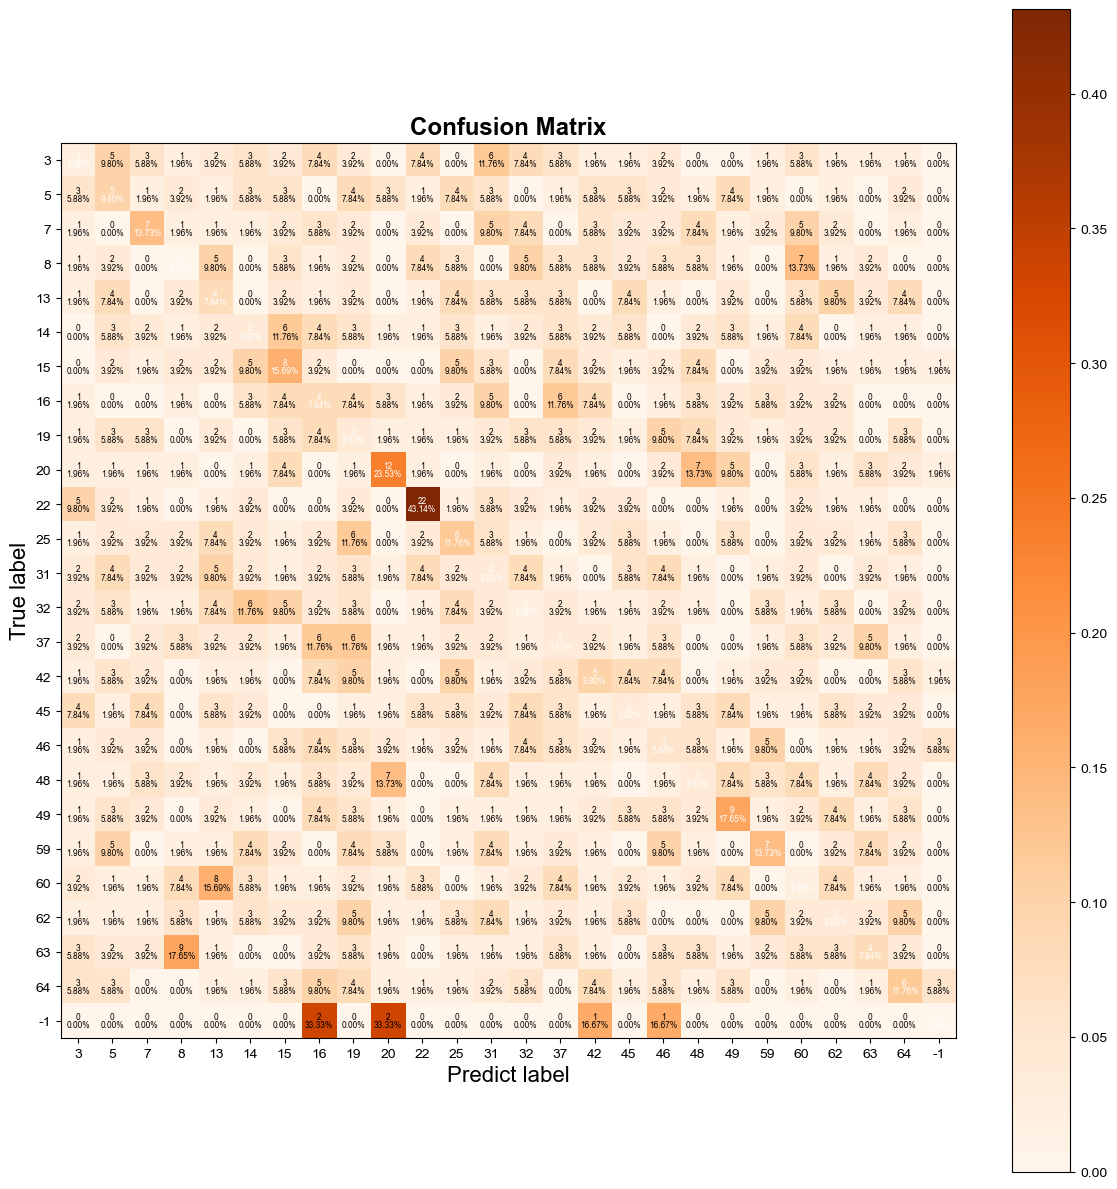

The accuracy of the model is 9.29%
The recall of the model is 16.76%
The precision of the model is 17.25%
The F1 of the model is 17.00%


In [22]:
train,test = dataset(datame,train_percent = 0.7)

fitting(train, test, feature_dimension = 3, K = 1)

confusion_matrix(test)

_,_,_,_ = score(test)

## Train the model with 9 dimension and NN classification

Done
feature_dimension =  9
Training done!
Testing done!
Prediction done!


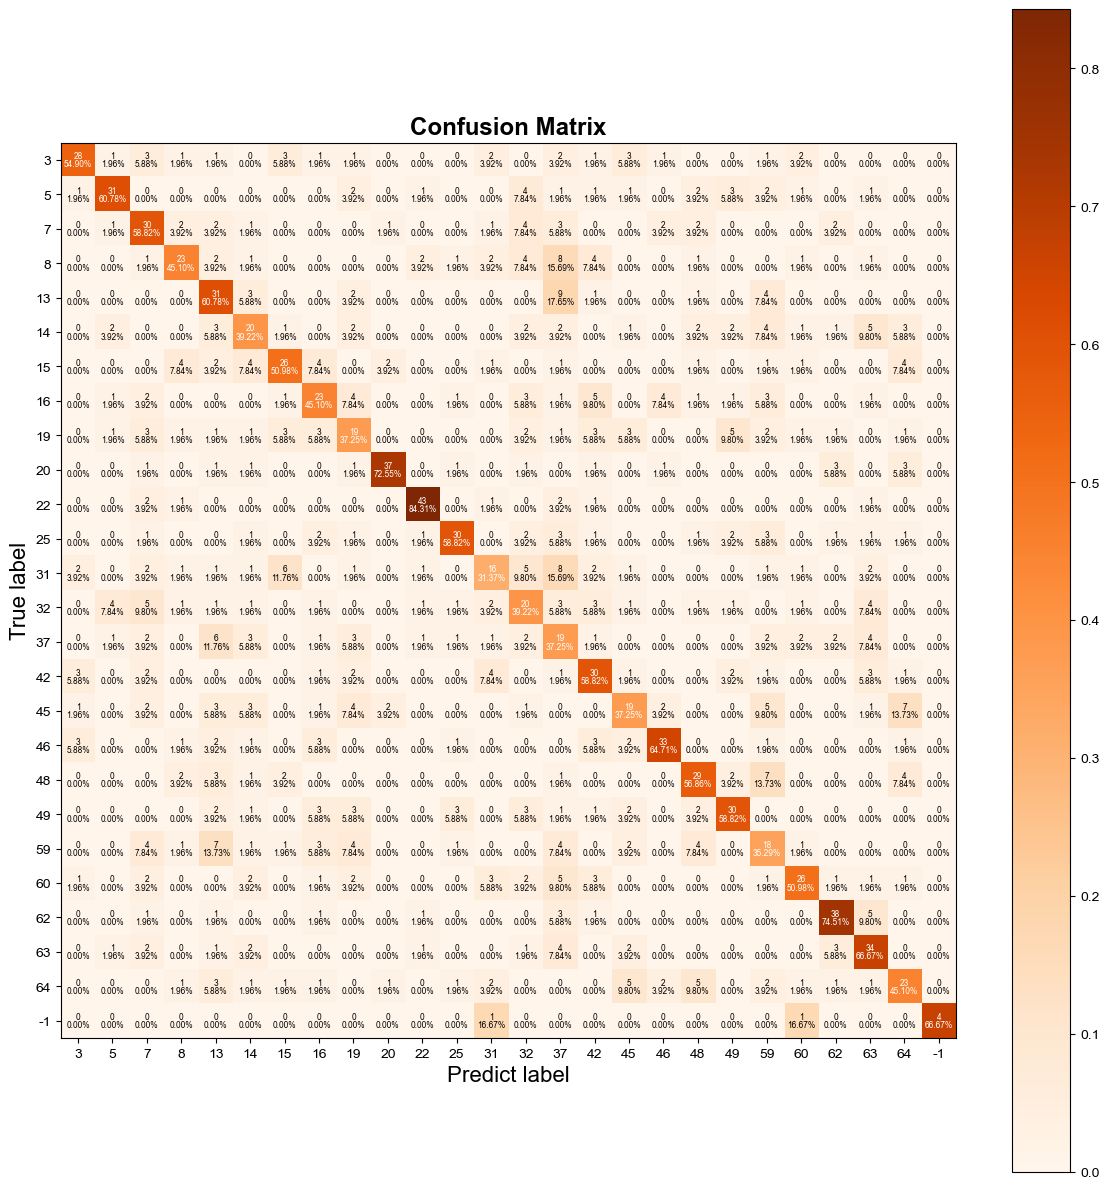

The accuracy of the model is 53.08%
The recall of the model is 68.34%
The precision of the model is 70.39%
The F1 of the model is 69.35%


In [23]:
train,test = dataset(datame,train_percent = 0.7)

fitting(train, test, feature_dimension = 9, K = 1)

confusion_matrix(test)

_,_,_,_ = score(test)

## Train the model with 25 dimension and NN classification

Done
feature_dimension =  25
Training done!
Testing done!
Prediction done!


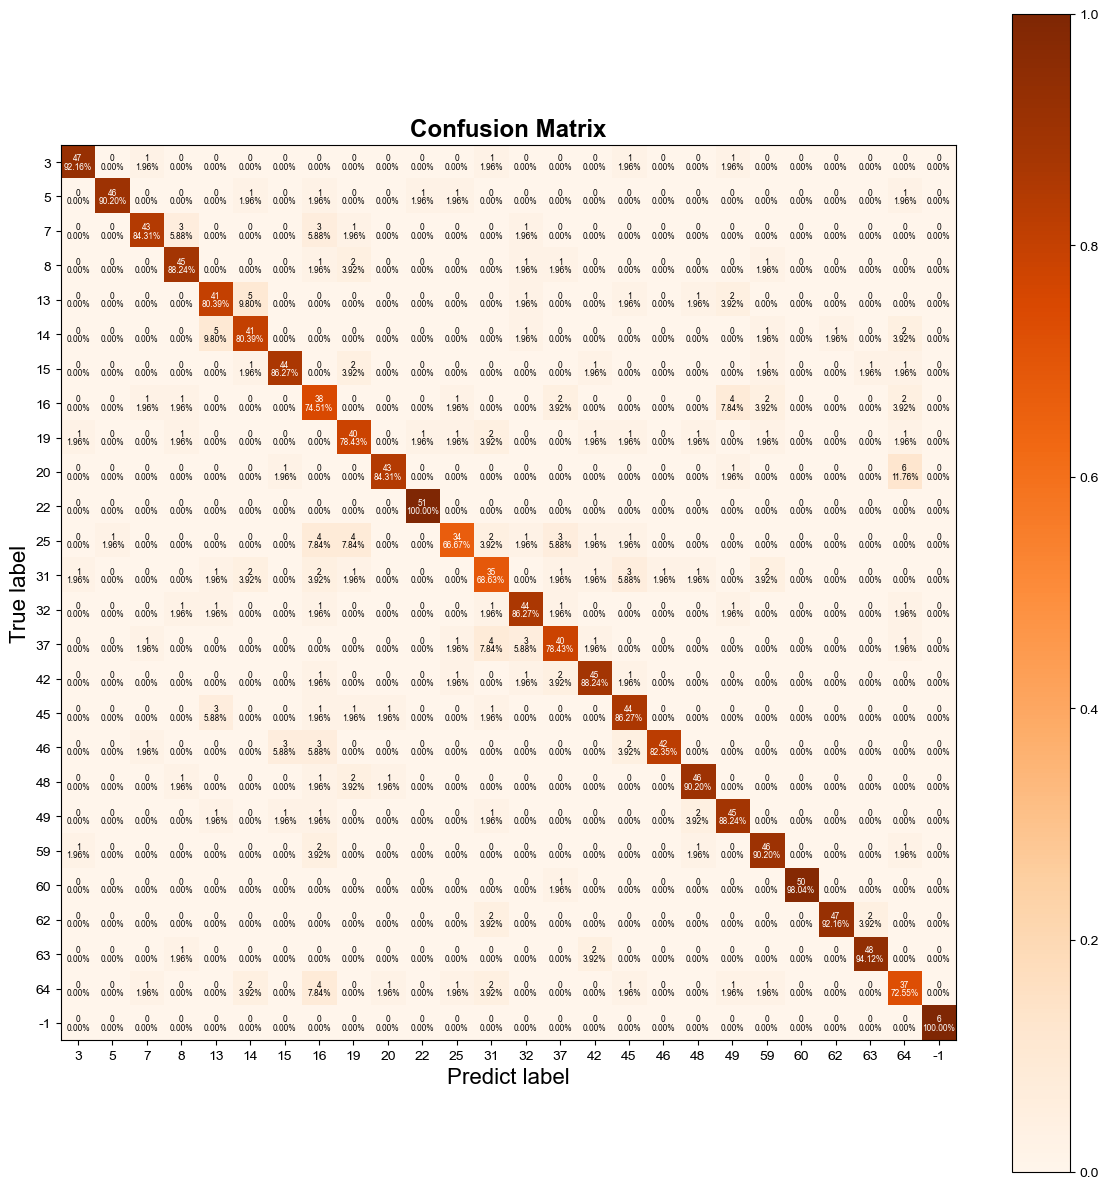

The accuracy of the model is 84.93%
The recall of the model is 91.81%
The precision of the model is 91.89%
The F1 of the model is 91.85%


In [24]:
train,test = dataset(datame,train_percent = 0.7)

fitting(train, test, feature_dimension = None, K = 1)

confusion_matrix(test)

_,_,_,_ = score(test)

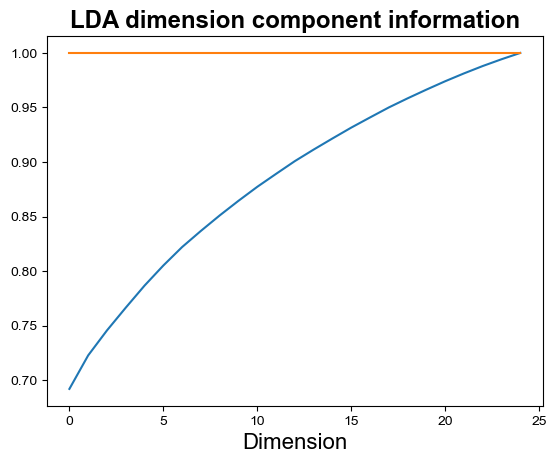

In [40]:
LDA_info(datame)

## Train the model with 9 dimension and 3NN classification 

Done
feature_dimension =  9
Training done!
Testing done!
Prediction done!


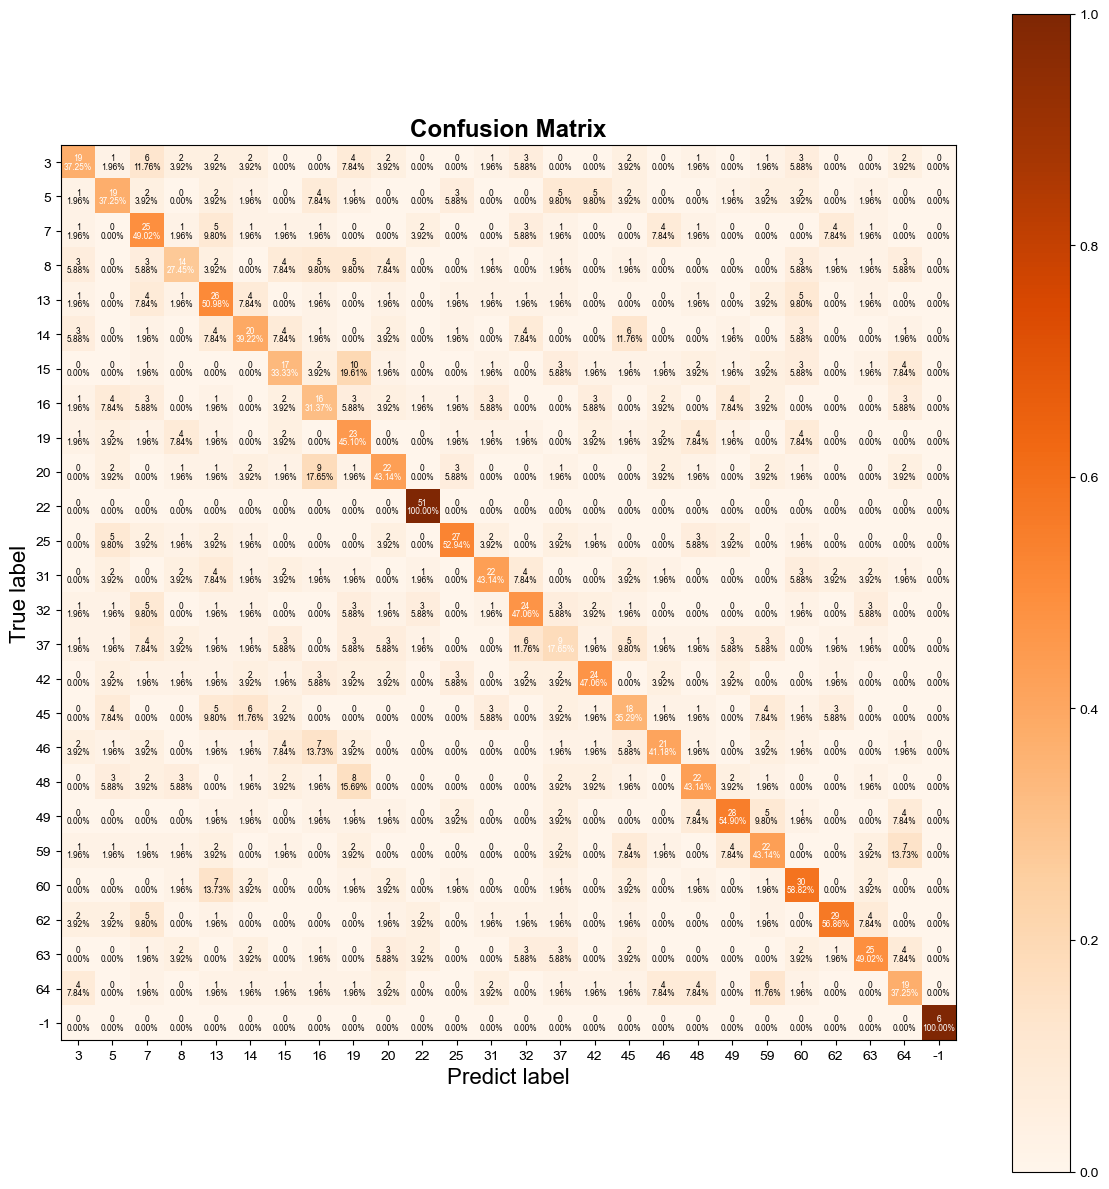

The accuracy of the model is 45.12%
The recall of the model is 62.15%
The precision of the model is 62.22%
The F1 of the model is 62.18%


In [41]:
train,test = dataset(datame,train_percent = 0.7)

fitting(train, test, feature_dimension = 9, K = 3)

confusion_matrix(test)

_,_,_,_ = score(test)

## Train the model with 9 dimension and 5NN classification 

Done
feature_dimension =  9
Training done!
Testing done!
Prediction done!


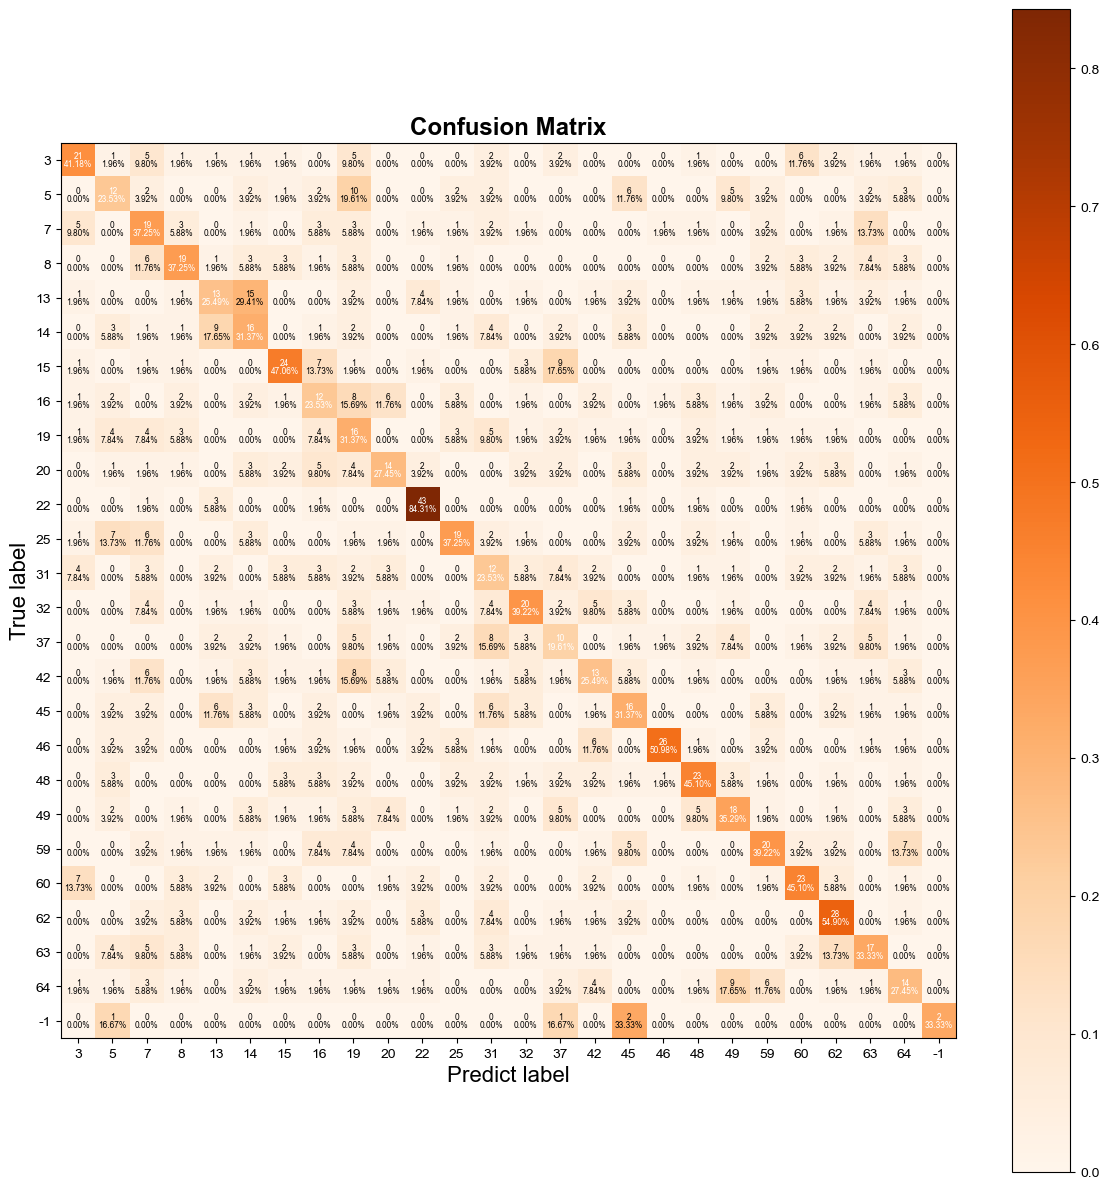

The accuracy of the model is 36.69%
The recall of the model is 54.71%
The precision of the model is 52.69%
The F1 of the model is 53.68%


In [42]:
train,test = dataset(datame,train_percent = 0.7)

fitting(train, test, feature_dimension = 9, K = 5)

confusion_matrix(test)

_,_,_,_ = score(test)

## Train the model with 9 dimension and 10NN classification 

Done
feature_dimension =  9
Training done!
Testing done!
Prediction done!


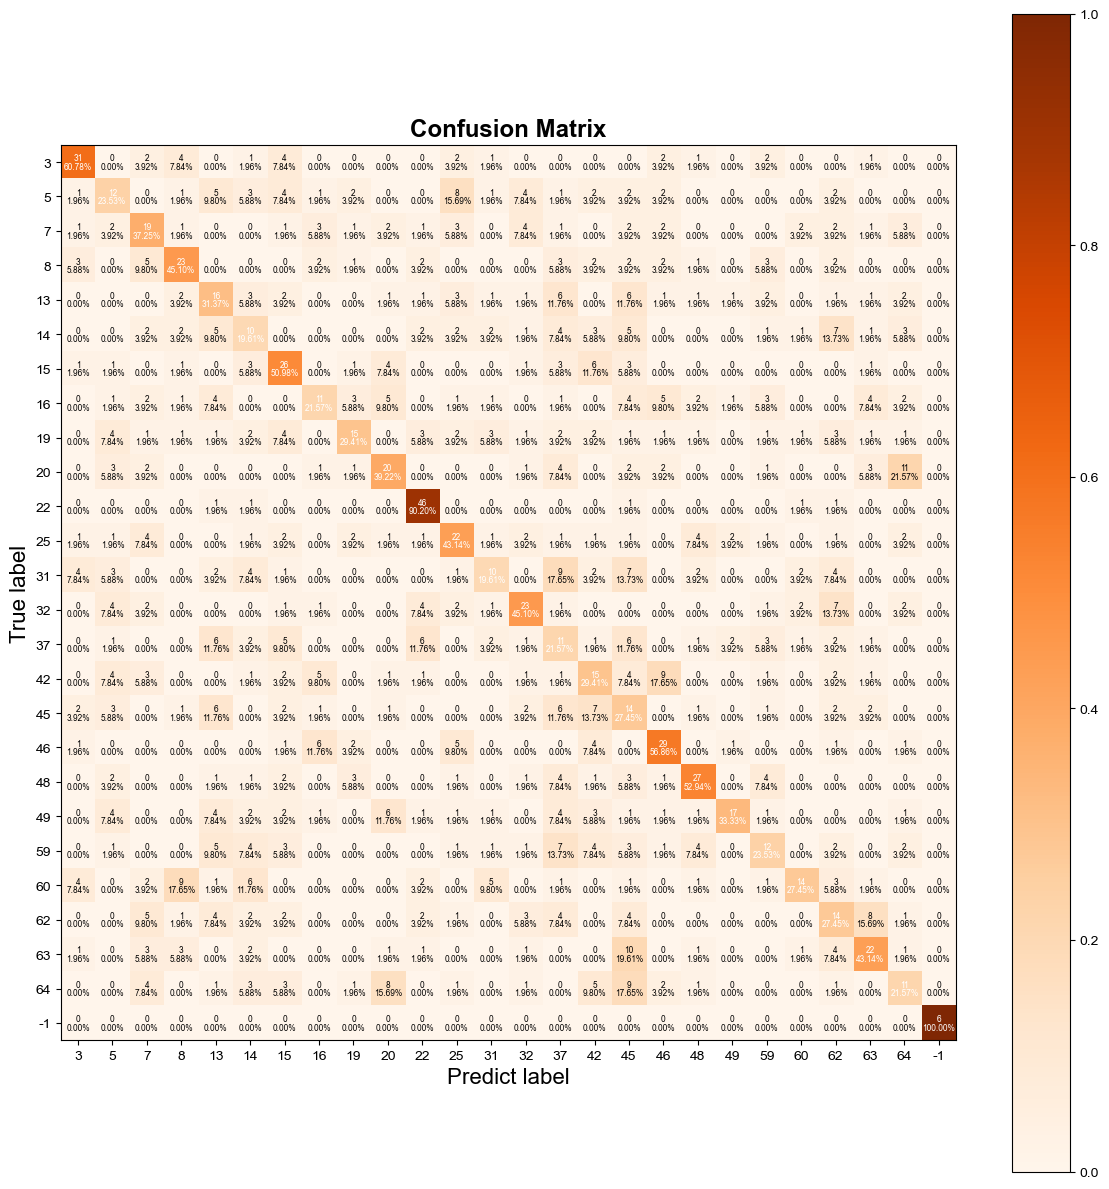

The accuracy of the model is 37.16%
The recall of the model is 54.65%
The precision of the model is 53.72%
The F1 of the model is 54.18%


In [43]:
train,test = dataset(datame,train_percent = 0.7)

fitting(train, test, feature_dimension = 9, K = 10)

confusion_matrix(test)

_,_,_,_ = score(test)